In [8]:
%load_ext autoreload
%autoreload 2

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, CacheDataset, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImage,
    LoadImaged,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensityd,
    EnsureTyped,
    Resized,
    CropForegroundd,
    Spacingd,
    SpatialPadd,
    CastToTyped
)
from monai.utils import set_determinism

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import os
from enum import Enum
from monai.transforms import Transform

class Modality(Enum):
    MR_T1 = 1
    MR_T2 = 2
    MR_T2_STAR = 3
    MR_FLAIR = 4
    MR_TOF_MRA = 5

def create_oasis_3_dataset(csv_path: str, dataset_root: str, modality: Modality, transform: Transform, cache_rate: float):
    train_df = pd.read_csv(csv_path, sep=";")
    train_df.fillna('', inplace=True)

    column_name = ""
    if modality == Modality.MR_T1:
        column_name = "MR T1w"
    elif modality == Modality.MR_T2:
        column_name = "MR T2w"
    elif modality == Modality.MR_T2_STAR:
        column_name = "MR T2*"
    elif modality == Modality.MR_FLAIR:
        column_name = "MR FLAIR"
    elif modality == Modality.MR_TOF_MRA:
        column_name = "MR TOF-MRA"
    else:
        assert(False)

    train_data = []
    for index, row in train_df.iterrows():
        rel_path = row[column_name]
        if not rel_path:
            continue
        image_path = os.path.join(dataset_root, rel_path)
        train_data.append({"image": image_path, "label" : row["label"]})
        
    return CacheDataset(data=train_data, transform=transform, cache_rate=cache_rate, num_workers=5, copy_cache=False)

In [35]:
dataset_root = "/mnt/f/OASIS-3-MR-Sessions-2D/"
resolution = 256
cache_rate = 1.0 # might need to change this based on the amount of memory available
batch_size = 16
modality = Modality.MR_T2_STAR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
foreground_crop_threshold = 0.1
train_table_path = "csv/oasis/oasis_3_multimodal_train.csv"
transform = Compose([
    LoadImaged("image", image_only=True),
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),  
    CastToTyped("label", dtype=np.float64),
    ScaleIntensityd("image"),
    CropForegroundd("image", source_key="image", select_fn=lambda x: x > foreground_crop_threshold, margin=5),
    Resized(keys=["image"], spatial_size=resolution, size_mode="longest"),
    SpatialPadd(keys=["image"], spatial_size=(resolution, resolution)),
    EnsureTyped("image", device=device),
    ]
)
train_ds = create_oasis_3_dataset(csv_path=train_table_path, dataset_root=dataset_root, modality=modality, transform=transform, cache_rate=cache_rate)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=batch_size, shuffle=True)

val_table_path = "csv/oasis/oasis_3_multimodal_val.csv"
val_ds = create_oasis_3_dataset(csv_path=val_table_path, dataset_root=dataset_root, modality=modality, transform=transform, cache_rate=cache_rate)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=batch_size, shuffle=True)

Loading dataset: 100%|██████████| 229/229 [00:07<00:00, 31.12it/s]


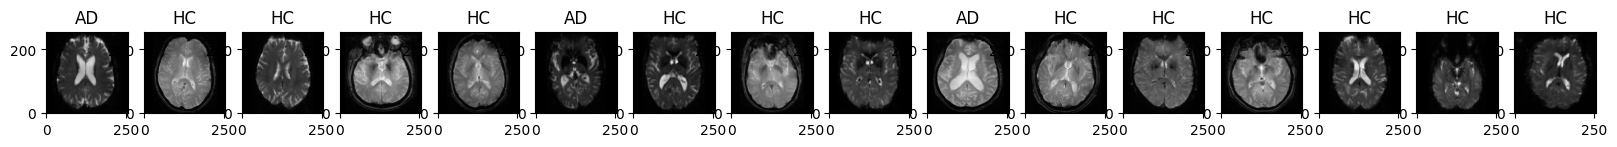

In [38]:
dataiter = iter(train_loader)
batch_sample = next(dataiter)
images = batch_sample["image"]
labels = batch_sample["label"]

classes = ["HC", "AD"]

plt.figure(figsize=(20, 12))
i = 0
for sample_data, sample_label in zip(images, labels):
    sample = sample_data.cpu()[0]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(sample.T, cmap='gray', origin='lower')
    plt.title(f"{classes[int(sample_label.cpu()[0])]}")  # Display the label as the title
    i += 1
plt.show()

### Define network and optimizer

In [39]:
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=1).to(device)
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
scaler = torch.cuda.amp.GradScaler()
max_epochs = 8
val_interval = 1
auc_metric = ROCAUCMetric()

### Training

In [40]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

y_pred_trans = Compose([Activations(sigmoid=True)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = torch.cat([i for i in decollate_batch(y, detach=False)], dim=0)
            y_pred_act = torch.cat([y_pred_trans(i) for i in decollate_batch(y_pred)], dim=0)
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            metric_values.append(result)
            acc_value = torch.eq((y_pred_act > 0.5).long(), y)
            acc_metric = acc_value.float().mean().item()
            del y_pred_act, y_onehot
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                #torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/8
1/130, train_loss: 0.6803
2/130, train_loss: 0.6785
3/130, train_loss: 0.6702
4/130, train_loss: 0.6745
5/130, train_loss: 0.6703
6/130, train_loss: 0.6599
7/130, train_loss: 0.6703
8/130, train_loss: 0.6607
9/130, train_loss: 0.6498
10/130, train_loss: 0.6528
11/130, train_loss: 0.6667
12/130, train_loss: 0.6534
13/130, train_loss: 0.6490
14/130, train_loss: 0.6552
15/130, train_loss: 0.6484
16/130, train_loss: 0.6411
17/130, train_loss: 0.6634
18/130, train_loss: 0.6464
19/130, train_loss: 0.6505
20/130, train_loss: 0.6338
21/130, train_loss: 0.6212
22/130, train_loss: 0.6399
23/130, train_loss: 0.6517
24/130, train_loss: 0.6515
25/130, train_loss: 0.6202
26/130, train_loss: 0.6149
27/130, train_loss: 0.6299
28/130, train_loss: 0.6492
29/130, train_loss: 0.6599
30/130, train_loss: 0.6373
31/130, train_loss: 0.6213
32/130, train_loss: 0.6089
33/130, train_loss: 0.6209
34/130, train_loss: 0.5996
35/130, train_loss: 0.5907
36/130, train_loss: 0.6095
37/130, train_lo